### Imports

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from cont_extraction import binarize
from cont_extraction import get_outline_contour
from cont_extraction import load_resize_image
from cont_extraction import snakeSmooth
from cont_extraction import choose_contour
from objSymmetrize import procrustes
from objSymmetrize import reorderPoints
from objSymmetrize import symmetrize
from objSymmetrize import rescale

### Test - Part 1 - Contour Extraction / Smoothing

We test out the contour extraction with a sample of vases in a folder, _pth_.

We go through each fil do the following:
1. Load and resize image.
1. Binarize and obtain 2 binarized images.
1. Get two sets of contours, one for each binarized image.
1. Choose the best contour.
1. Smooth the contour.

In [3]:
filenames = []
smoothedContours = []
pth = "C:\\Users\\arian\\Downloads\\testVases"
for file in os.listdir(pth):
    filenames.append(file)
    # 1) Load and resize image:
    img = load_resize_image(pth+"\\"+file,resize=0.7)
    # 2) Binarize
    mpx,mpy,finalImages = binarize(img,white_or_black='both')
    # 3) Find outline contours:
    x1,y1 = get_outline_contour(finalImages[0],mpx,mpy)
    x2,y2 = get_outline_contour(finalImages[1],mpx,mpy)
    # 4) Choose best contour:
    x,y = choose_contour(x1,y1,x2,y2)
    # 5) Basic contour smoothing:
    xs,ys = snakeSmooth(img,x,y)
    # 6) Save contours into list:
    smoothedContours.append([xs,ys])
    
n = len(filenames)

print("Extracted contours from "+str(n)+" images!")

Extracted contours from 4 images!


### Test - Part 2 - Symmetrization / Reordering

In [4]:
symmetrizedContours = []

n = len(filenames)

for i in range(0,n):
    x = smoothedContours[i][0]
    y = smoothedContours[i][1]
    # 1) Symmetrize (and cut ends if desired -- it is the default)
    xsym,ysym = symmetrize(x,y,cutEnds=True,reparamPoints=250)
    # 2) Reorder (and rotate 180 degrees if neccessary -- it is the default)
    newx,newy = reorderPoints(xsym,ysym,rotate=True)
    symmetrizedContours.append([newx,newy])
    
print("Symmetrized "+str(n)+" contours!")

Computing Karcher Mean of 2 curves in SRVF space..
updating step: 1
updating step: 2
Computing Karcher Mean of 2 curves in SRVF space..
updating step: 1
updating step: 2
Computing Karcher Mean of 2 curves in SRVF space..
updating step: 1
updating step: 2
Computing Karcher Mean of 2 curves in SRVF space..
updating step: 1
updating step: 2
Symmetrized 4 contours!


### Test - Part 3 - Procrustes

We Procrustes align the vases to a template. Here, for now, the template will just be the first vase.

In [5]:
alignedContours = []
# 1) Set the template to be the first vase and that to the final list of aligned contours:
F0 = np.column_stack([symmetrizedContours[0][0],symmetrizedContours[0][1]])
alignedContours.append([symmetrizedContours[0][0],symmetrizedContours[0][1]])

# 2) Go through all the other vases and Procrustes align to the template vase:
for i in range(1,n):
    F = np.column_stack([symmetrizedContours[i][0],symmetrizedContours[i][1]])
    _,Fp,_,_,_ = procrustes(F0,F)
    # 3) Rescale to make sure it's within the desired range:
    xp,yp = rescale(Fp[:,0],Fp[:,1])
    alignedContours.append([xp,yp])
    
print("Procrustes aligned "+str(n)+" contours")

Procrustes aligned 4 contours


### Saving Examples

Examples of how to save contours as a CSV in a loop.

#### Example 1: Saving the original smooth contours (unequal contour lengths)

In [6]:
namesRepeated = []
xCoordinates = []
yCoordinates = []
pointNumbers = []

for i,name in enumerate(filenames):
    x = smoothedContours[i][0]
    y = smoothedContours[i][1]
    length = len(x)
    # 1) Add the filename to the list (repeated 'length' times):
    namesRepeated.extend([name]*length)
    # 2) Add point numbers:
    pointNumbers.extend(list(range(1,length+1)))
    # 3) Add the x and y coordinates to the list:
    xCoordinates.extend(x)
    yCoordinates.extend(y)
    
# 4) Save into Pandas dataframe:
smoothedDF = pd.DataFrame([namesRepeated,xCoordinates,yCoordinates,pointNumbers]).T
# 5) Rename columns:
smoothedDF = smoothedDF.rename(columns={0:'Filename',1:'X',2:'Y',3:'pointOrder'})
# 6) Save as CSV:
smoothedDF.to_csv('smoothedContours.csv',index=False)

#### Example 2: Saving the final symmetrized / aligned contours (equal contour lengths)

In [7]:
length = 250

data = np.zeros((3,n*length))

# 1) Create dataframe with names:
dfNames = pd.DataFrame([nm for name in filenames for nm in [name]*length])
dfNames = dfNames.rename(columns={0:'Filename'})


for i,name in enumerate(filenames):
    x = alignedContours[i][0]
    y = alignedContours[i][1]
    data[0,length*i:length*(i+1)] = x # 2) Add x coordinates
    data[1,length*i:length*(i+1)] = y # 3) Add y coordinates
    data[2,length*i:length*(i+1)] = list(range(1,length+1)) # 4) Add point numbers
    
dfData = pd.DataFrame(data).T
dfData = dfData.rename(columns={0:'X',1:'Y',2:'pointOrder'})


# 5) Merge the two dataframes to create one final dataframe:
alignedDF = pd.concat([dfNames,dfData],axis=1)

# 6) Save as CSV:
alignedDF.to_csv('alignedContours.csv',index=False)

### Plotting Examples

#### Example 1: Images with contours overlayed
Here, we'll save individual plots in a loop, into a separate folder.
<br>Note that the path of the desired folder needs to be specified.

In [8]:
originalPath = "C:\\Users\\arian\\Downloads\\testVases\\"
newPath = "C:\\Users\\arian\\Downloads\\Contours\\"

for i,file in enumerate(filenames):
    img = load_resize_image(originalPath+file,resize=0.7)
    x = smoothedContours[i][0]
    y = smoothedContours[i][1]
    fig,ax = plt.subplots()
    ax.imshow(img,cmap='gray')
    ax.plot(x,y,'-r',linewidth=2)
    ax.axis('off')
    plt.savefig(newPath+'Contour_'+file,bbox_inches = 'tight',pad_inches=0.0)
    plt.close()


#### Example 2: Contours in same plot
Here, we'll save one plot with n subplots.
<br>This time we'll save it as a pdf.

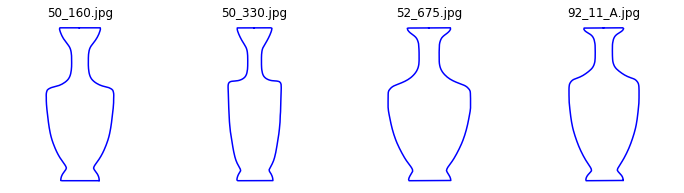

In [9]:
n = len(filenames)

fig,ax = plt.subplots(1,n,figsize=(3*n,3))

for n,file in enumerate(filenames):
    x = alignedContours[n][0]
    y = alignedContours[n][1]
    ax[n].plot(x,y,'-b')
    ax[n].set_xlim([-1.6,1.6])
    ax[n].set_ylim([-1.6,1.6])
    ax[n].axis('off')
    ax[n].set_title(file)
    
plt.savefig('Symmetrized_Vases_Example.pdf',dpi=600,bbox_inches='tight',pad_inches=0.5)